<a href="https://colab.research.google.com/github/ibribr/ML/blob/master/olivetti_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets.olivetti_faces import fetch_olivetti_faces
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout
from tensorflow.keras.utils import plot_model
from keras import regularizers
from keras.losses import mse, binary_crossentropy

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.olivetti_faces module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Data shape: (400, 4096)
Label shape: (400,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


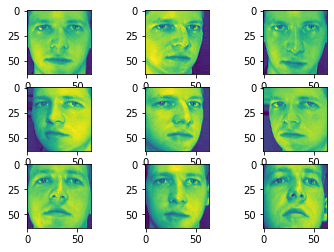

(320, 4096)
(80, 4096)
[0 0 0 0 0 0 0 0 0 0]
train: [13  5  3 12 10 20 24 35 11 13]
test: [ 1 35 18 16 39 23 32 19  3 34]
[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10] [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8] [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2]


In [2]:
# Fetch data and have a look
faces = fetch_olivetti_faces()
x, y = faces['data'], faces['target']
print(f'Data shape: {x.shape}')
print(f'Label shape: {y.shape}')
# (400, 4096)
# (400,)

print(np.unique(y))

# create a grid of 3x3 images
for i in range(0, 9):
  plt.subplot(330 + 1 + i)
  plt.imshow(x[i].reshape(64, 64))

# show the plot
plt.show()


# divide data into training, validation and testing (shuffle)
xtrain, xtest, ytrain, ytest = train_test_split(x,y, stratify=y, test_size=0.2, random_state=42)
print(xtrain.shape)
print(xtest.shape)
print(y[0:10])
print('train:',ytrain[0:10])
print('test:', ytest[0:10])
print(np.bincount(y), np.bincount(ytrain), np.bincount(ytest))






# confusion matrix

#cross-validation  - SGD, BGD and MBGD



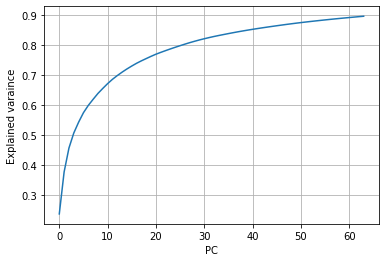

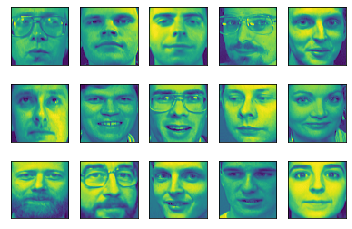

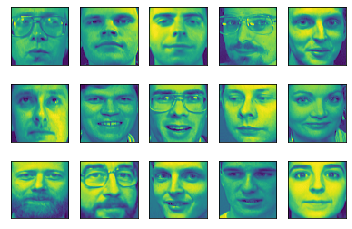

In [3]:
# use PCA for diensionality reduction - reconstruct images using a subset of features
pca = PCA(n_components=8*8)  # n_components=0.8 - number of components is automatically choosen to acount for at least 80% of the total variance
pca.fit(x)
cumsum = np.cumsum(pca.explained_variance_ratio_)
#print(cumsum)

plt.figure()
plt.plot(range(len(cumsum)), cumsum)
plt.grid()
plt.xlabel('PC')
plt.ylabel('Explained varaince')
plt.show()

x_reduced = pca.fit_transform(xtest)
x_recovered = pca.inverse_transform(x_reduced)

#print(x_reduced.shape)

def disp_digits(x):
  fig, ax = plt.subplots(3,5)
  ax = ax.flatten()
  ims = []
  for i in range(len(ax)):
    ax[i].imshow(xtest[i].reshape(64,64), interpolation='nearest', animated=True)
    #ax[i].set_title(str(y[i]))
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)

disp_digits(xtest)
disp_digits(x_recovered)

In [4]:
# # use autoencoder - reconstruct using a compressed representation (code)
# call neural network API: sequential model is a linear stack of layers
autoencoder = Sequential()
autoencoder.add(Dense(units = 1024, activation='relu', input_dim = 64*64, name='encoder_layer1'))   # encoder layers
autoencoder.add(Dense(units = 512, activation='relu', input_dim =  1024, name='encoder_layer2'))
autoencoder.add(Dense(units =  64, activation='relu', input_dim =  512, name='encoder_layer3'))


autoencoder.add(Dense(units = 512, activation='relu', name='decoder_layer1'))                    # decoder layers
autoencoder.add(Dense(units = 1024, activation='relu', name='decoder_layer2'))
autoencoder.add(Dense(units = 64*64, activation='sigmoid', name='decoder_layer3'))    #linear - softmax

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])   #mean_squared_error

autoencoder.summary()
plot_model(autoencoder, to_file='AE_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image 
Image('AE_plot.png')

history = autoencoder.fit(x = xtrain, y= xtrain, epochs=1000, batch_size=32, shuffle=True,\
                    validation_data=(xtrain, xtrain), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer1 (Dense)       (None, 1024)              4195328   
_________________________________________________________________
encoder_layer2 (Dense)       (None, 512)               524800    
_________________________________________________________________
encoder_layer3 (Dense)       (None, 64)                32832     
_________________________________________________________________
decoder_layer1 (Dense)       (None, 512)               33280     
_________________________________________________________________
decoder_layer2 (Dense)       (None, 1024)              525312    
_________________________________________________________________
decoder_layer3 (Dense)       (None, 4096)              4198400   
Total params: 9,509,952
Trainable params: 9,509,952
Non-trainable params: 0
______________________________________________

In [ ]:
# plot accuracy and loss


(80, 64)
(80, 64)
3/3 [==============================] - 0s 2ms/step


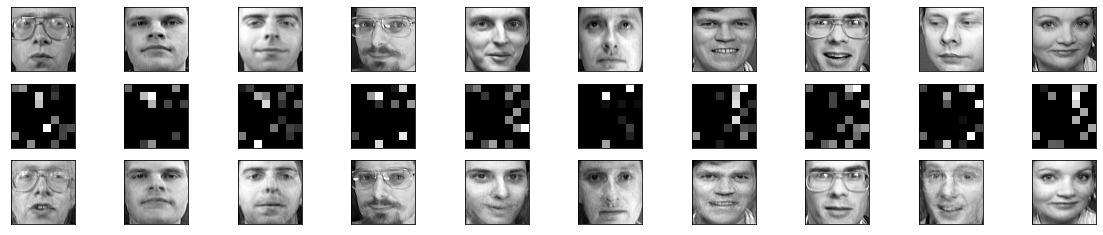

In [5]:
# test trained autoencoder
encoder = Model(inputs = autoencoder.input, outputs = autoencoder.layers[2].output)
encoded_imgs = encoder.predict(xtest)

print(encoded_imgs.shape)

# retrieve the last layer of the autoencoder model

encoded_input = Input(shape=(64,))
decoder_layer = autoencoder.layers[3](encoded_input)
decoder_layer = autoencoder.layers[4](decoder_layer)
decoder_layer = autoencoder.layers[5](decoder_layer)

decoder = Model(inputs = encoded_input, outputs = decoder_layer)

decoded_imgs = decoder.predict(encoded_imgs)

print(encoded_imgs.shape)

predicted_imgs = autoencoder.predict(xtest, verbose=1)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(xtest[i].reshape(64, 64))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded images
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 8))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(64, 64))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 17938.643
start iteration
done sorting
end inner loop
Iteration 1, inertia 16579.586
start iteration
done sorting
end inner loop
Iteration 2, inertia 16126.732
start iteration
done sorting
end inner loop
Iteration 3, inertia 15996.29
start iteration
done sorting
end inner loop
Iteration 4, inertia 15934.631
start iteration
done sorting
end inner loop
Iteration 5, inertia 15934.631
center shift 0.000000e+00 within tolerance 3.087450e-04
Initialization complete
start iteration
done sorting
end inner loop
Iteration 0, inertia 18191.576
start iteration
done sorting
end inner loop
Iteration 1, inertia 17224.285
start iteration
done sorting
end inner loop
Iteration 2, inertia 16786.256
start iteration
done sorting
end inner loop
Iteration 3, inertia 16632.61
start iteration
done sorting
end inner loop
Iteration 4, inertia 16495.53
start iteration
done sorting
end inner loop
Iteration 5, inertia 16399.846

<Figure size 576x576 with 0 Axes>

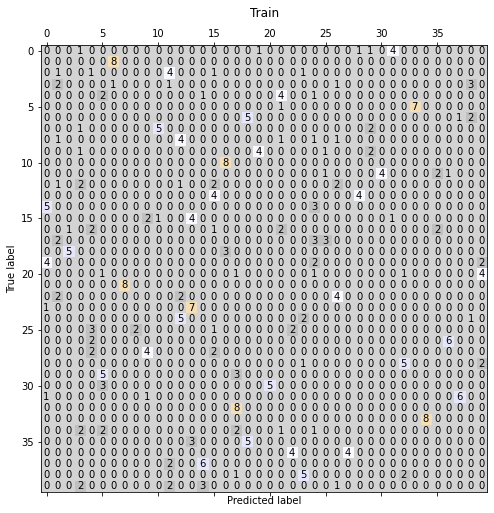

<Figure size 576x576 with 0 Axes>

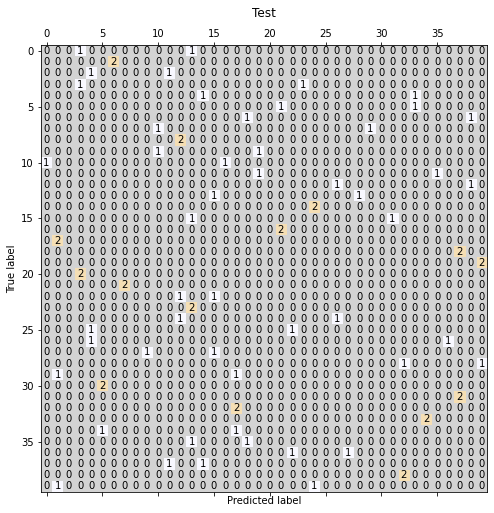

In [6]:
# unsupervised algorithm
#Create KMC Classifier
kmeans = KMeans(n_clusters=40, max_iter=10000, algorithm = 'auto', random_state=7, verbose=1)

#Train the model using the training sets
encoded_imgs = encoder.predict(xtrain)
kmeans.fit(encoded_imgs)

#Predict the response for test dataset
encoded_imgs = encoder.predict(xtest)
ypred = kmeans.predict(encoded_imgs)
print(ypred[0,])
print(ytest[0,])

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", accuracy_score(ytest, ypred))

cmap = ListedColormap(['lightgrey', 'silver', 'ghostwhite', 'lavender', 'wheat'])
plt.rcParams["figure.figsize"] = (8,8)

#confusion matrix
def cm(ytest, ypred, title):
  cm = confusion_matrix(ytest, ypred)

  plt.figure()
  plt.matshow(cm, cmap=cmap)
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
  
  plt.title(title)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

cm(ytrain, kmeans.predict(encoder.predict(xtrain)), title='Train')
cm(ytest, kmeans.predict(encoder.predict(xtest)), title='Test')

In [7]:
# supervised algorithm
print(y.shape)
print(ytrain[0])
print(ytrain.shape)

ytrain_ = to_categorical(ytrain)
ytest_ = to_categorical(ytest)

print(ytrain_[0])

(400,)
13
(320,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
model = Sequential()
model.add(Dense(56, activation='relu', input_shape=(8*8, ), name='hidden_layer'))
model.add(Dense(40, activation='softmax', name='output_layer'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()
plot_model(model, to_file='mnist_keras.png', show_shapes=True, show_layer_names=True)

enc_train = encoder.predict(xtrain).reshape(320,8*8)
enc_test =encoder.predict(xtest).reshape(80,8*8)
print(enc_train.shape)
print(enc_test.shape)


history = model.fit(enc_train, ytrain_, epochs=100, batch_size=32)
test_loss, test_accu = model.evaluate(enc_test, ytest_)
print(test_loss, test_accu)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 56)                3640      
_________________________________________________________________
output_layer (Dense)         (None, 40)                2280      
Total params: 5,920
Trainable params: 5,920
Non-trainable params: 0
_________________________________________________________________
(320, 64)
(80, 64)
Epoch 1/100
10/10 [==============================] - 0s 2ms/step - loss: 4.8207 - accuracy: 0.0281
Epoch 2/100
10/10 [==============================] - 0s 2ms/step - loss: 3.9690 - accuracy: 0.0562
Epoch 3/100
10/10 [==============================] - 0s 2ms/step - loss: 3.5488 - accuracy: 0.1063
Epoch 4/100
10/10 [==============================] - 0s 2ms/step - loss: 3.2303 - accuracy: 0.1688
Epoch 5/100
10/10 [==============================] - 0s 2ms/step - loss: 2.9588 - accuracy: 0.2625


(320,)
(320,)


<Figure size 576x576 with 0 Axes>

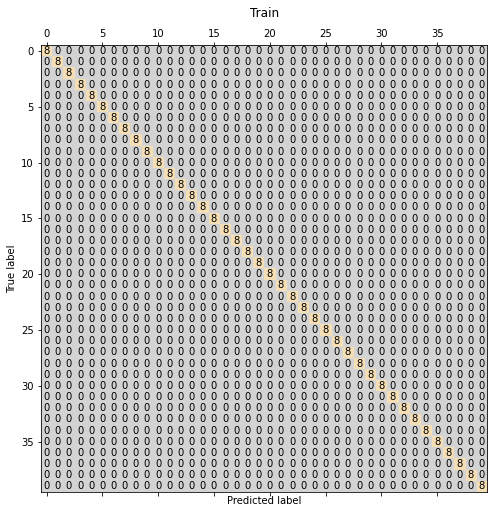

(80,)
(80,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
Precision score: 0.7870833333333332
Recall score   : 0.75
(79,)
(79,)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 576x576 with 0 Axes>

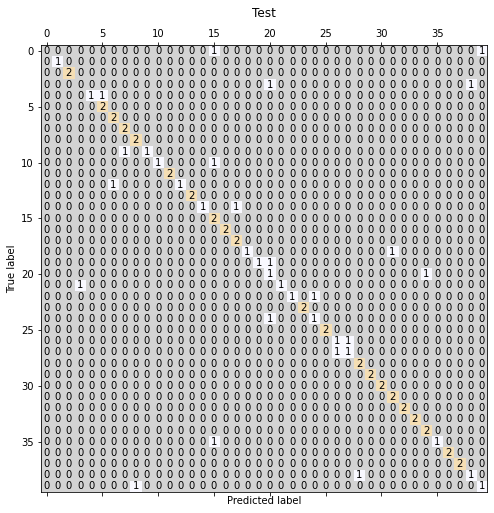

In [32]:
cmap = ListedColormap(['lightgrey', 'silver', 'ghostwhite', 'lavender', 'wheat'])
plt.rcParams["figure.figsize"] = (8,8)

#confusion matrix
def cm(ytest, ypred, title):
  print(ytest.shape)
  print(ypred.shape)

  cm = confusion_matrix(ytest, ypred)

  plt.figure()
  plt.matshow(cm, cmap=cmap)
  
  for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
      plt.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
  
  plt.title(title)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()


ypred_train = model.predict(enc_train)
ypred_train = np.argmax(ypred_train, axis=-1)
cm(ytrain, ypred_train, title='Train')



ypred_test = model.predict(enc_test)
ypred_test = np.argmax(ypred_test, axis=-1)
print(ypred_test.shape)
print(ytest.shape)

print(np.unique(ypred_test))
print(np.unique(ytest))

print('Precision score:', precision_score(ytest, ypred_test, average='macro'))
print('Recall score   :', recall_score(ytest, ypred_test, average='macro'))

cm(ytest[1:], ypred_test[1:], title='Test')


